### This file will use the Rotational Forest Classifier from the Aeon library

In [ ]:
import _Data_Processing
from importlib import reload

'''
this function returns 7 objects:
	data: sets of data as X_train, X_val, X_ind, y_train, y_val, y_ind
	feature_list: list of all feature names with a column index (dict)
'''

reload(_Data_Processing)

lstm_format = False

X, X_train, X_val, X_ind,\
y, y_train, y_val, y_ind,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_ndx_full.csv'
	,indp_size  =		0.01
	,test_size  =		0.20
	,shfl_splt	=		False
	,t_start    =		570
	,t_end		=		720
	,mod_type	=		'Area_Classification'
	,target_t	=		30
	,num_class	=		2
	,split_val	=		5
	,verbose	=		1
	,scaler		=		'Standard'
	,frmt_lstm	=		lstm_format
	,time_steps =		5
	,keep_price =		True
	,optm_data	=		True
)

In [ ]:
import joblib
joblib.dump(scaler, 'scaler/tmp.joblib')

In [ ]:
import _Data_Rotating
from importlib import reload
'''
This function returns 4 items.
-	2D array of X partitions, by featurespace and samplespace
-	1D array of index-lists for each featurespace-partition specific features
-	1D array of featurespace-partition specific rotation transformer functions
-	1D array of y partitions for each samplespace partition.
'''

reload(_Data_Rotating)

X_train_parts, X_find_parts, X_trans_parts, y_parts = _Data_Rotating.rotate_partitions(
	X				=	X_train
	,y				=	y_train
	,n_feat_parts	=	8
	,feat_subsets	=	feature_subsets
	,feat_part_type	=	'by_subset'
	,fraction_feats	=	0.75
	,no_feat_overlap=	False
	,feats_for_all	=	[]
	,rotation_type	=	'PCA'
	,rotation_filter=	False
	,filter_type	=	'Retention'
	,filter_value	=	0.95
	,n_sample_parts	=	1
	,smpl_part_type	=	'Even'
	,sample_overlap	=	0.9
	,sample_shuffle	=	False
	,lstm_format	=	lstm_format
)

'''
all partitions
	X_train_parts
all sample partitions of THE featurespace partition i
	X_train_parts[i]
The single partition of THE samplespace partition j of THE featurespace partition i
	X_train_parts[i][j] -- -- -- This is now a set of trainable data
'''

In [ ]:
for featureset in feature_subsets:
	print(featureset)

In [ ]:
import _Modelset_Training
reload(_Modelset_Training)

_Modelset_Training.show_available_model_types()

In [ ]:
import _Modelset_Training
from importlib import reload

'''
Function returns a 3D list of trained models that are fit to the resepective dataset.
	Dim1:	Featurespace, here are the subsetctions/partitions for each unique set of features
	Dim2:	Samplespace, here are the subsetctions/partitions for each unique set of samples
	Dim3:	Modelspace, here are the individual models trained on a unique partition
'''
reload(_Modelset_Training)

models = _Modelset_Training.train_models(
	model_types	=	['nn']
	,data_parts	=	X_train_parts
	,findx_parts=	X_find_parts
	,trans_parts=	X_trans_parts
	,trgt_parts	=	y_parts
	,X_valid	=	X_val
	,y_valid	=	y_val
	,param_mode	=	'custom'
	,cst_mod_prm=	[{
		'optimizer_type'	:	'Adam'
		,'optimizer_kwarg':{
			'learning_rate'	:	0.0005
			#,'momentum'		:	0.9
			}
		,'time_steps'		:	5
		,'LSTM'				:	False
		,'shuffle_train'	:	True
		,'epochs'			:	5
		,'rlr_patience'		:	20
		,'architecture'	:	'default_deep'
		#,'external_cw'	:	_Utility.get_class_weights(y_train)
		}]
	,tnr_verbose=	True
	,lstm_frmt	=	lstm_format
	,use_cls_wt	=	True
)

In [ ]:
import _Model_Evaluation
import _Neural_Net

reload(_Model_Evaluation)
reload(_Neural_Net)

_Model_Evaluation.evaluate_models(
		models=models
		,X_findx=X_find_parts
		,X_trans=X_trans_parts
		,X_train=X_train_parts
		,y_train=y_parts
		,X_test=X_val
		,y_test=y_val
		,prfm_gnrl	=	'all'
		,prfm_stat	=	'all'
		,disp_mthd	=	'as_value'
		,test_whch	=	'independent'
		,pred_type	=	'classification'
		,lstm_frmt	=	lstm_format
)

In [ ]:
import _Metamodel
from importlib import reload
import _Utility

reload(_Metamodel)
metamodel, prediction_set = _Metamodel.train_test_meta_model(
	models		=	models
	,X_findx	=	X_find_parts
	,X_trans	=	X_trans_parts
	,X_test		=	X_val
	,y_test		=	y_val
	,val_size	=	0.2
	,shuffle	=	True
	,metam_type =	'NN'
	,use_cls_wt =	True
	,use_mm_params=	True
	,metam_params={
		'optimizer_type':	'Adam'
		,'optimizer_kwarg':{
			'learning_rate'	:	0.001
			#,'momentum':0.9
			}
		,'time_steps'		:	5
		,'LSTM'				:	False
		,'shuffle_train'	:	True
		,'epochs'			:	75
		,'batch_size'		:	30
		,'rlr_patience'		:	10
		,'architecture'	:	'default_deep'
		#,'custom_val_data'	:	(X_train, y_train)
		}
)

final connective test will be:
-	casually train fair/good metamodel
-	load into a master model
-	predict on X_ind
-	score model
-	model performs at same level
-	save model
-	load same model
-	test on X_ind again
-	will have indentical score to pre save/load

In [ ]:
import _Data_Processing
from importlib import reload
reload(_Data_Processing)
lstm_format = False
X_tall, X_test, _, __,\
y_tall, y_test, ___, ____,\
feature_subsets =\
_Data_Processing.preprocess_data(
	file_name   =		'betaset_tmp.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		645
	,t_end		=		900
	,mod_type	=		'Classification'
	,target_t	=		5
	,num_class	=		2
	,split_val	=		5
	,verbose	=		1
	,scaler		=		'Standard'
	,frmt_lstm	=		lstm_format
	,time_steps =		5
	,keep_price =		False
)

In [ ]:
i = [0,5]

print(i[0])
print(i[1])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import _Master_Model
reload(_Master_Model)
from importlib import reload

master = _Master_Model.Master(
	model_depth		=	2
	,all_models 	=	[models, metamodel]
	,lvl0_formatters=	[X_find_parts, X_trans_parts]
)

#	train	val		ind

test_on_X = X_ind
test_on_y = y_ind

m_pred = master.master_predict(test_on_X, threshold=0.5)
print(accuracy_score(test_on_y, m_pred))

#master.master_predict_fullth(test_on_X, test_on_y, definition='min')

#print((m_pred[0]))

#Create the confusion matrix
cm = confusion_matrix(test_on_y, m_pred)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', \
			xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Meta-Model Independent Test')
plt.show()

In [ ]:
master.save_model()

loaded chunk 1 of size: 125400164 -> 64675164
loaded chunk 2 of size: 125400164 -> 64575164
loaded chunk 3 of size: 125400164 -> 64675164
loaded chunk 4 of size: 125400164 -> 64675164
loaded chunk 5 of size: 125400164 -> 64675164
loaded chunk 6 of size: 125400164 -> 64675164
loaded chunk 7 of size: 125400164 -> 64675164
loaded chunk 8 of size: 125400164 -> 64575164
loaded chunk 9 of size: 125400164 -> 64675164
loaded chunk 10 of size: 7905380 -> 3951196
concat chunks
concatted chunks
Success.
Size of dataset:	586152276
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.float64'>
	201226 Samples Dropped.



2025-01-31 17:05:11.617534: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 17:05:11.729281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738361111.781897     594 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738361111.796364     594 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 17:05:11.905829: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

 85/793 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

I0000 00:00:1738361119.640827    1740 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(25350, 8)
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
0.5341617357001972


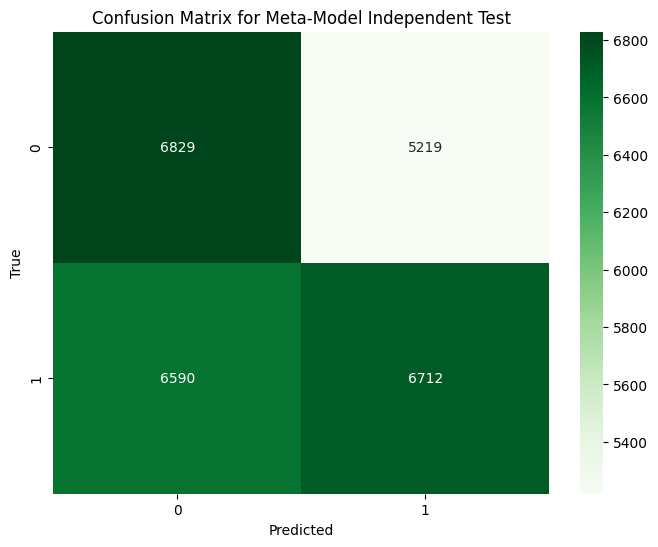

In [1]:









import _Data_Processing
from importlib import reload
import joblib
reload(_Data_Processing)
lstm_format = False
X_load, _, _, __,\
y_load, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_full.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		645
	,t_end		=		800
	,mod_type	=		'Area_Classification'
	,target_t	=		45
	,num_class	=		2
	,split_val	=		5
	,verbose	=		0
	,scaler		=		'Custom'
	,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,time_steps =		5
	,keep_price =		False
	,indices	=		0
)

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import _Master_Model
from importlib import reload
reload(_Master_Model)

test_on_X = X_load
test_on_y = y_load

loadmodel = _Master_Model.Master(
	model_depth=2
)
loadmodel.load_model('pred1_63p2_acc-645-800')
m_pred = loadmodel.master_predict(test_on_X, threshold=0.5)
print(accuracy_score(test_on_y, m_pred))

#Create the confusion matrix
cm = confusion_matrix(test_on_y, m_pred)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', \
			xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Meta-Model Independent Test')
plt.show()

In [19]:
import matplotlib.pyplot as plt

import _Data_Processing
from importlib import reload
import joblib
reload(_Data_Processing)
lstm_format = False
X_loadraw, _, _, __,\
y_loadraw, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_full.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		645
	,t_end		=		800
	,mod_type	=		'Area_Classification'
	,target_t	=		45
	,num_class	=		2
	,split_val	=		5
	,verbose	=		0
	,scaler		=		'Standard'
	,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,time_steps =		5
	,keep_price =		True
	,indices	=		0
)


loaded chunk 1 of size: 125400164 -> 64675164
loaded chunk 2 of size: 125400164 -> 64575164
loaded chunk 3 of size: 125400164 -> 64675164
loaded chunk 4 of size: 125400164 -> 64675164
loaded chunk 5 of size: 125400164 -> 64675164
loaded chunk 6 of size: 125400164 -> 64675164
loaded chunk 7 of size: 125400164 -> 64675164
loaded chunk 8 of size: 125400164 -> 64575164
loaded chunk 9 of size: 125400164 -> 64675164
loaded chunk 10 of size: 7905380 -> 3951196
concat chunks
concatted chunks
Success.
Size of dataset:	586152276
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.float64'>
	201226 Samples Dropped.



In [3]:
cm_vals = []
for i in range(len(m_pred)):
	if(test_on_y[i] == 0):
		if(m_pred[i] == 0):
			cm_vals.append(0)
		if(m_pred[i] == 1):
			cm_vals.append(1)
	if(test_on_y[i] == 1):
		if(m_pred[i] == 0):
			cm_vals.append(2)
		if(m_pred[i] == 1):
			cm_vals.append(3)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(X_loadraw)
df['score'] = cm_vals
#df['mpred'] = m_pred
df['target'] = y_loadraw
kept_indices = df.index[~(df['score'] % 2 == 0)].tolist()
df = df.drop(df[df['score']%2==0].index).reset_index(drop=True)
df = df.drop(columns=['score']).reset_index(drop=True)
#pd.set_option('display.max_rows',None)
co = df.corr()['target'].drop('target')
print(co.sort_values())
p = co.nlargest(5).index.tolist()
n = co.nsmallest(5).index.tolist()
feats = p+n

477   -0.072224
478   -0.063864
479   -0.056401
6     -0.047741
465   -0.046398
         ...   
53     0.075912
58     0.075932
56     0.076819
54     0.077344
55     0.078332
Name: target, Length: 519, dtype: float64


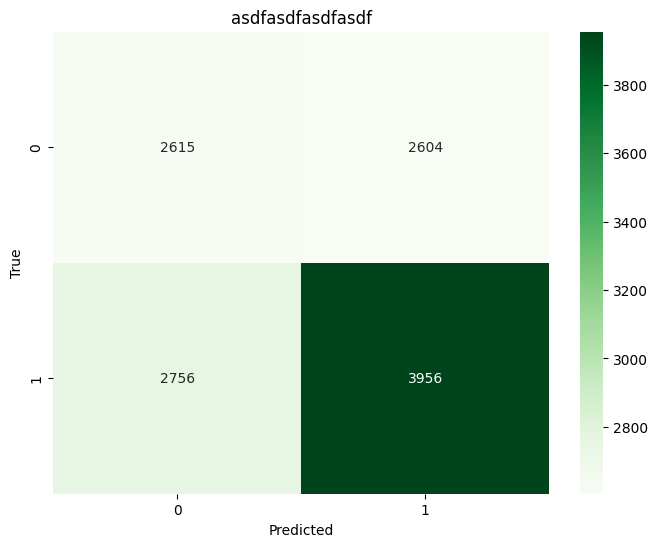

In [5]:
from sklearn.svm import SVC
from _Utility import get_class_weights

df_pair = pd.DataFrame(X_loadraw)
df_pair = df_pair.iloc[kept_indices].reset_index(drop=True)
df_pair = df_pair.iloc[:, feats]

X_svm = df_pair.values
y_svm = df['target'].values

clf = SVC(kernel='linear',C=1.0,class_weight=get_class_weights(df['target'])).fit(X_svm, y_svm)

y_svmpred = clf.predict(X_svm)

#Create the confusion matrix
cm = confusion_matrix(df['target'], y_svmpred)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', \
			xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'asdfasdfasdfasdf')
plt.show()

In [1]:
import matplotlib.pyplot as plt

import _Data_Processing
from importlib import reload
import joblib
reload(_Data_Processing)
lstm_format = False
X_test, _, _, __,\
y_test, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_test.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		645
	,t_end		=		800
	,mod_type	=		'Area_Classification'
	,target_t	=		45
	,num_class	=		2
	,split_val	=		5
	,verbose	=		0
	,scaler		=		'Custom'
	,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,time_steps =		5
	,keep_price =		False
	,indices	=		0
)

import matplotlib.pyplot as plt

import _Data_Processing
from importlib import reload
import joblib
reload(_Data_Processing)
lstm_format = False
X_testraw, _, _, __,\
y_testraw, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_test.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		645
	,t_end		=		800
	,mod_type	=		'Area_Classification'
	,target_t	=		45
	,num_class	=		2
	,split_val	=		5
	,verbose	=		0
	,scaler		=		'Standard'
	,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,time_steps =		5
	,keep_price =		True
	,indices	=		0
)

loaded chunk 1 of size: 125400164 -> 64600164
loaded chunk 2 of size: 18408884 -> 9395364
concat chunks
concatted chunks
Success.
Size of dataset:	74083444
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.float64'>
	25577 Samples Dropped.

loaded chunk 1 of size: 125400164 -> 64600164
loaded chunk 2 of size: 18408884 -> 9395364
concat chunks
concatted chunks
Success.
Size of dataset:	74083444
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.float64'>
	25577 Samples Dropped.



97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(3093, 8)
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0.5758163595215001


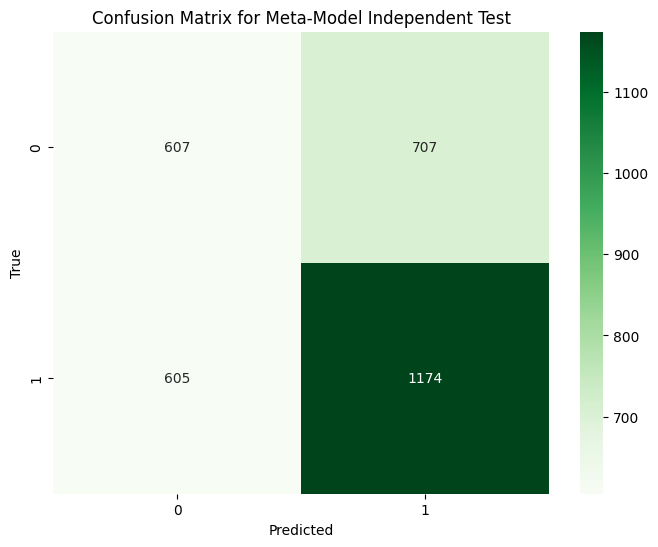

INDEPENDENT SET LEVEL-2 PRECISION: 0.687015503875969


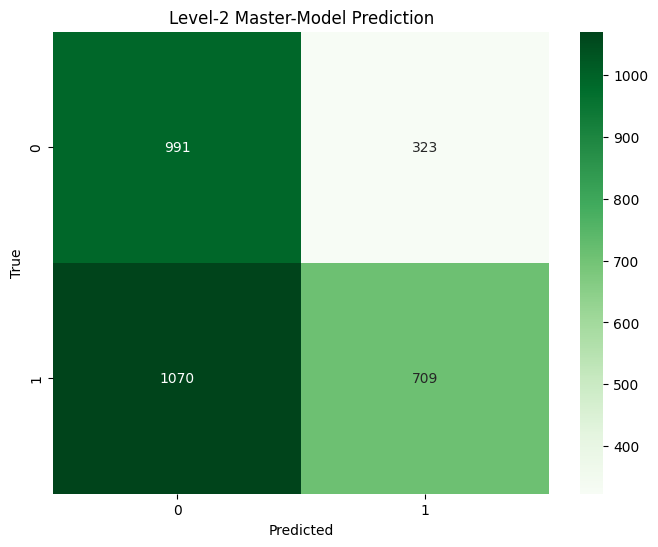

In [7]:
from sklearn.metrics import precision_score
import numpy as np

loadmodel = _Master_Model.Master(
	model_depth=2
)
loadmodel.load_model('pred1_63p2_acc-645-800')
m_pred = loadmodel.master_predict(X_test, threshold=0.5)
print(accuracy_score(y_test, m_pred))

#Create the confusion matrix
cm = confusion_matrix(y_test, m_pred)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', \
			xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Meta-Model Independent Test')
plt.show()

cm_vals = []
for i in range(len(m_pred)):
	if(test_on_y[i] == 0):
		if(m_pred[i] == 0):
			cm_vals.append(0)
		if(m_pred[i] == 1):
			cm_vals.append(1)
	if(test_on_y[i] == 1):
		if(m_pred[i] == 0):
			cm_vals.append(2)
		if(m_pred[i] == 1):
			cm_vals.append(3)

df = pd.DataFrame(X_testraw)
df['score'] = cm_vals
df['mpred'] = m_pred
df['target'] = y_testraw
kept_indices = df.index[~(df['score'] % 2 == 0)].tolist()
#df = df.drop(df[df['score']%2==0].index).reset_index(drop=True)
df = df.drop(columns=['score']).reset_index(drop=True)

df_test = pd.DataFrame(X_testraw)
df_test = df_test.iloc[:, feats]

X_svm = df_test.values
y_svm = df['target'].values

y_svmpred = m_pred

#'polishing' predictions based on if level-1 predicted (1)
for p in range(len(y_svmpred)):
	if(y_svmpred[p] == 1):
		y_svmpred[p] = clf.predict(X_svm[p].reshape(1, -1))

print(f'INDEPENDENT SET LEVEL-2 PRECISION: {precision_score(df['target'], y_svmpred)}')
#Create the confusion matrix
cm = confusion_matrix(df['target'], y_svmpred)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', \
			xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Level-2 Master-Model Prediction')
plt.show()

19


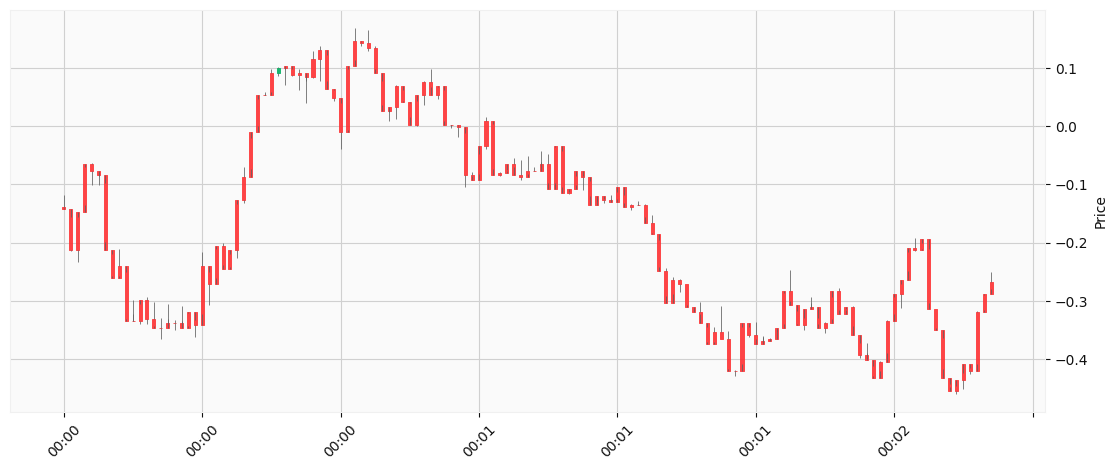

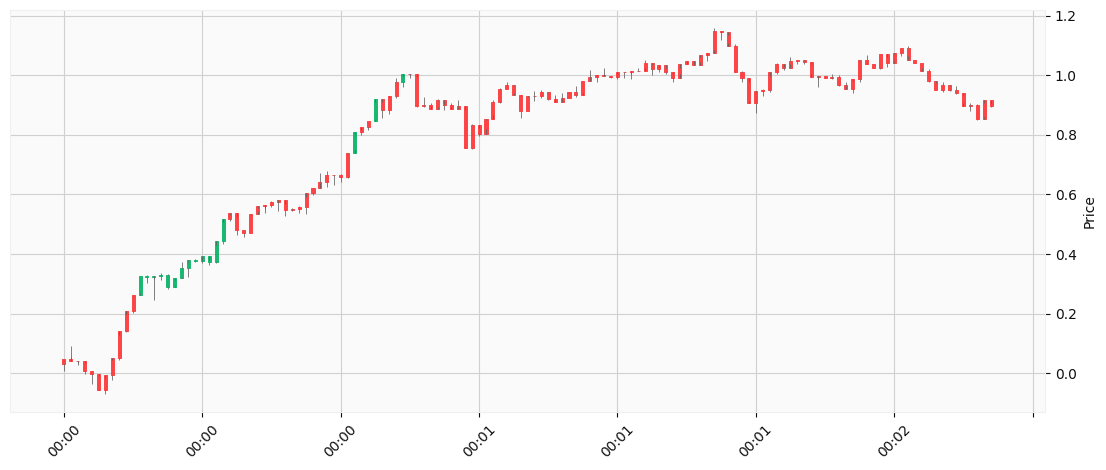

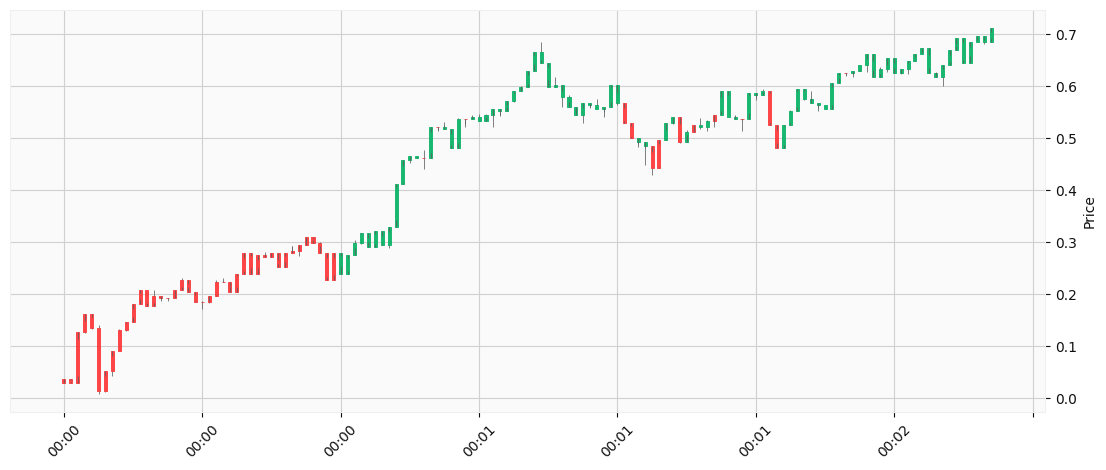

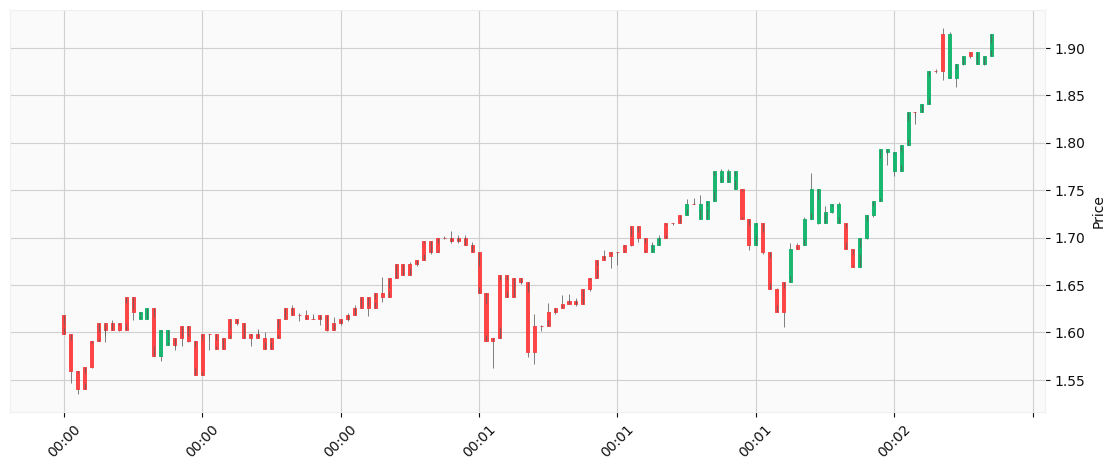

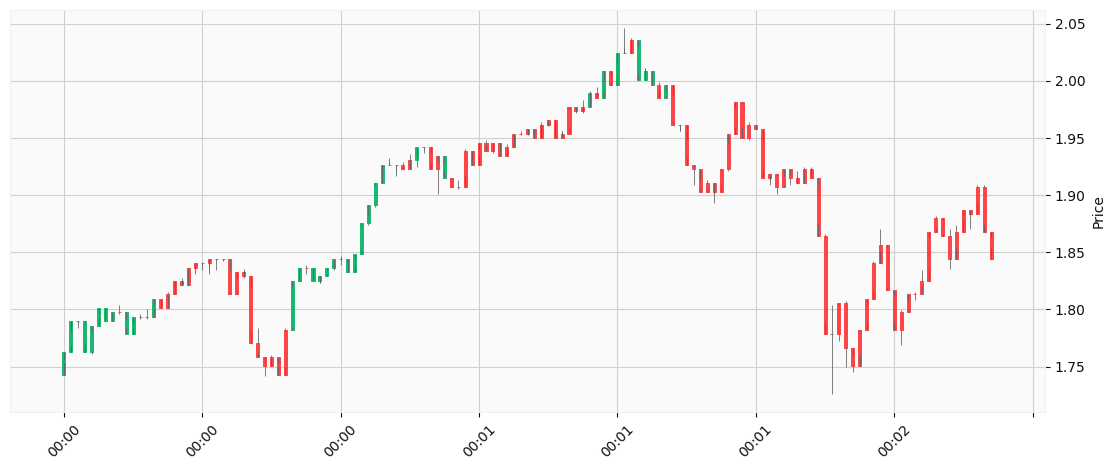

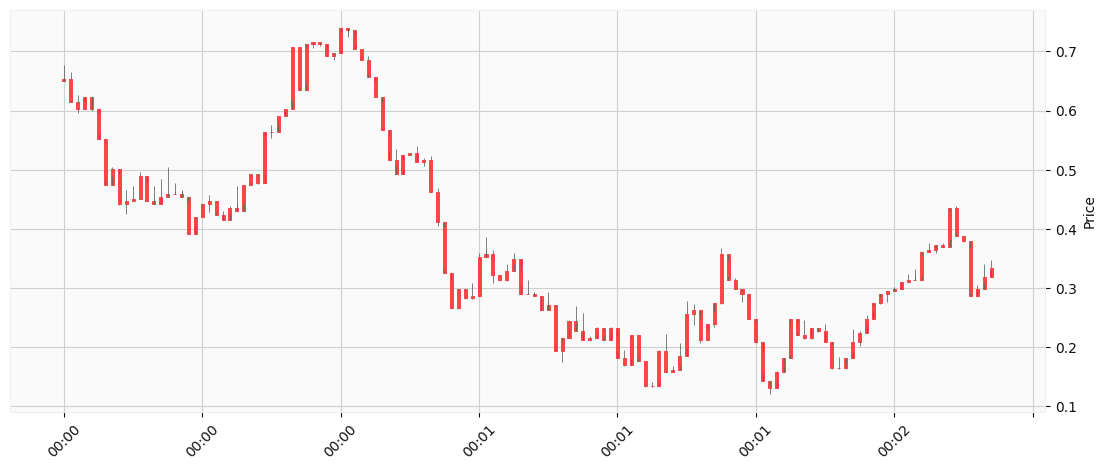

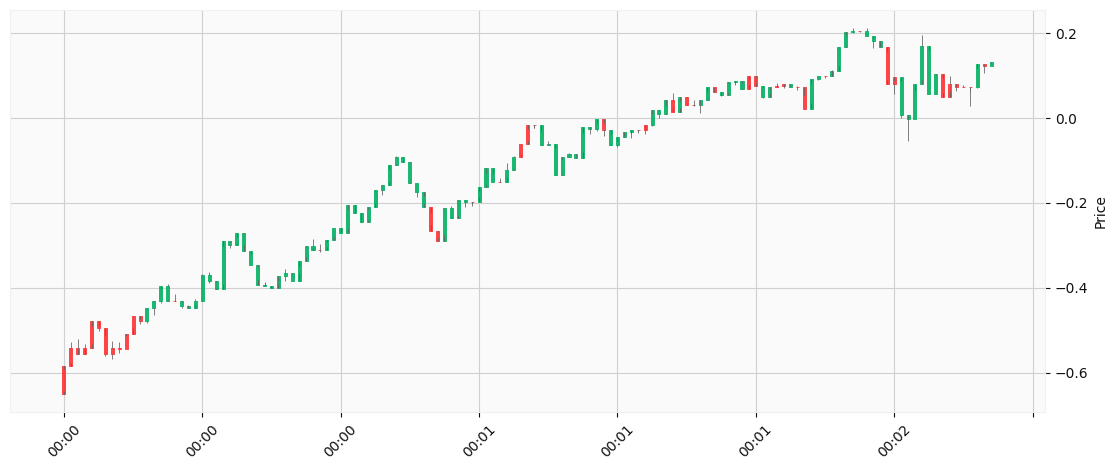

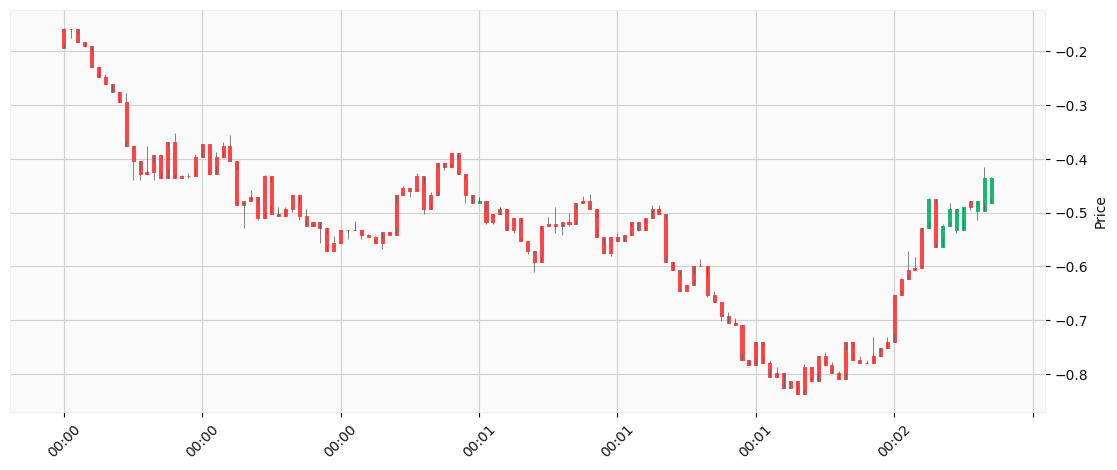

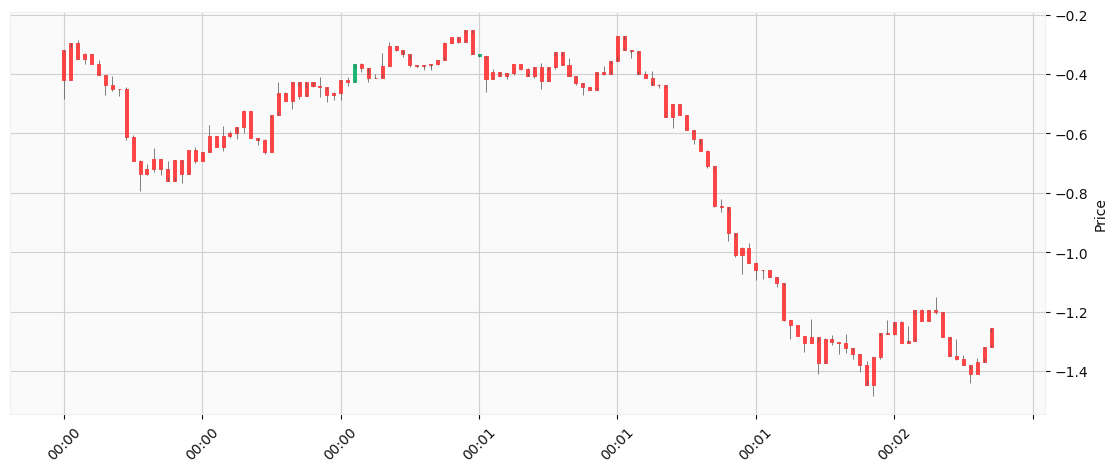

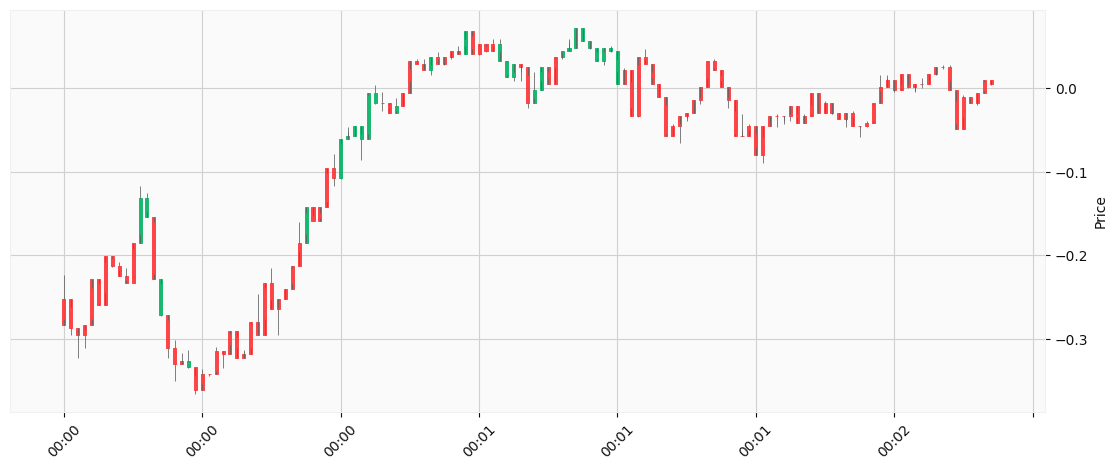

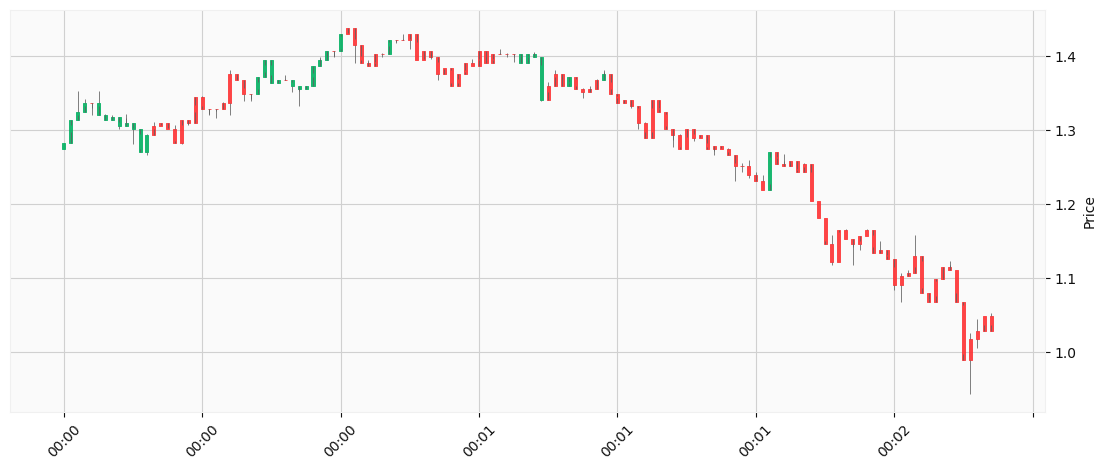

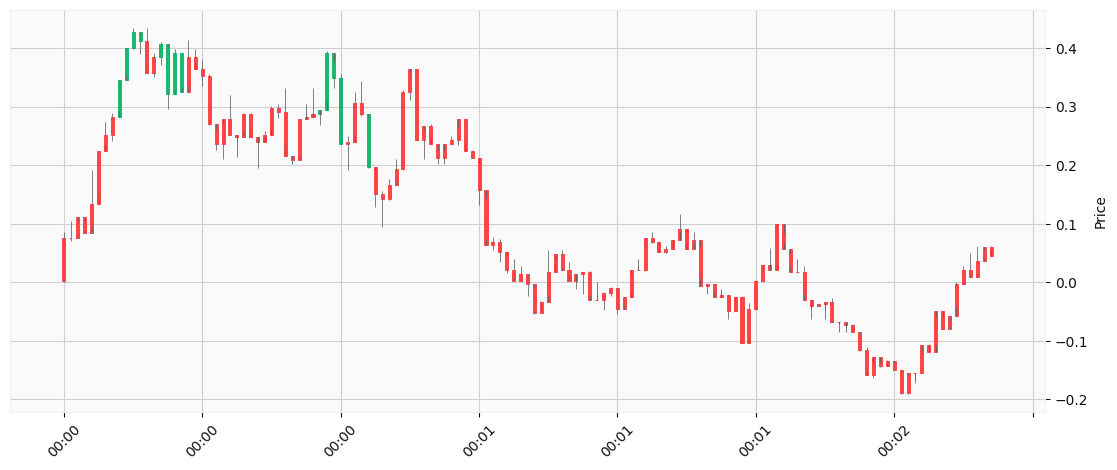

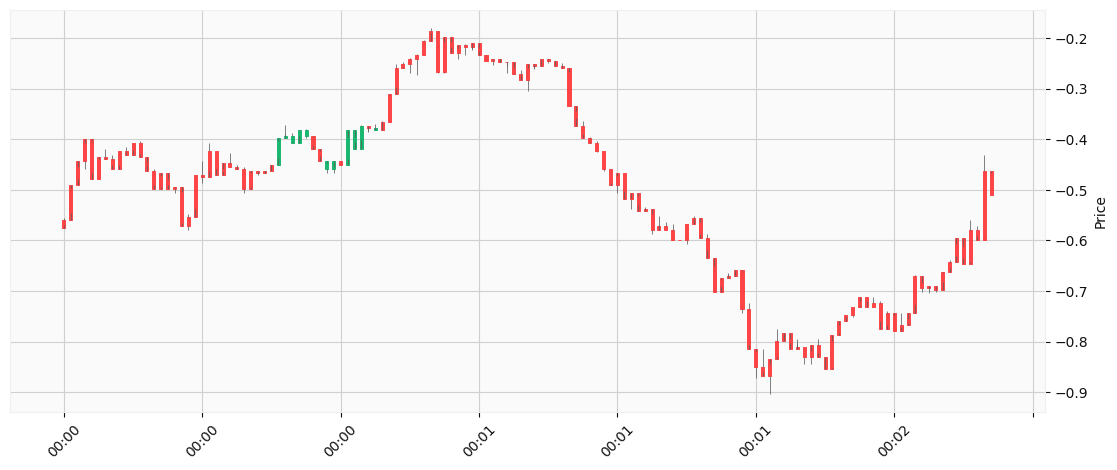

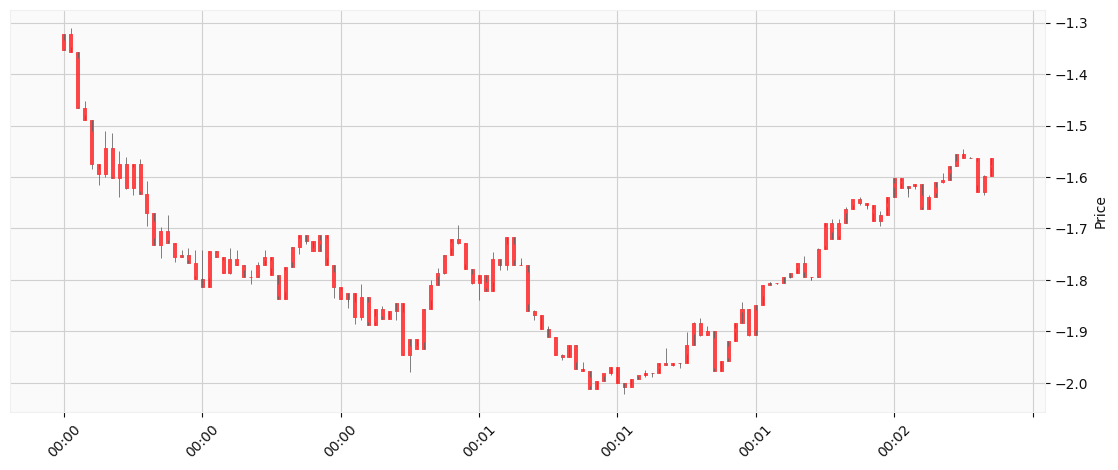

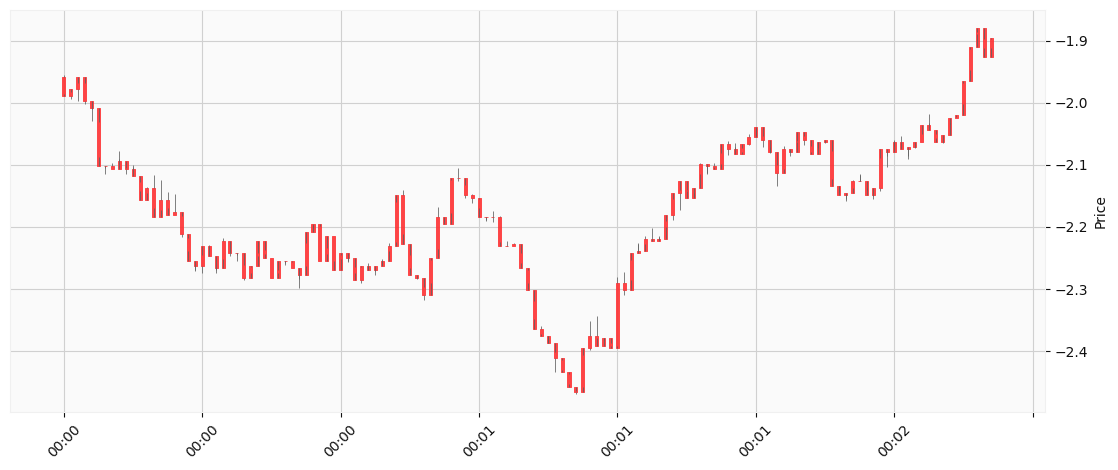

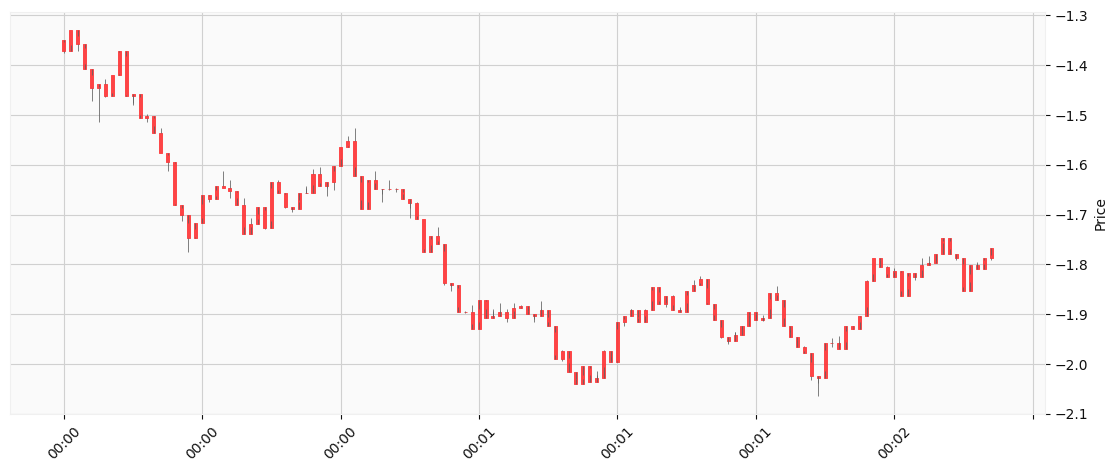

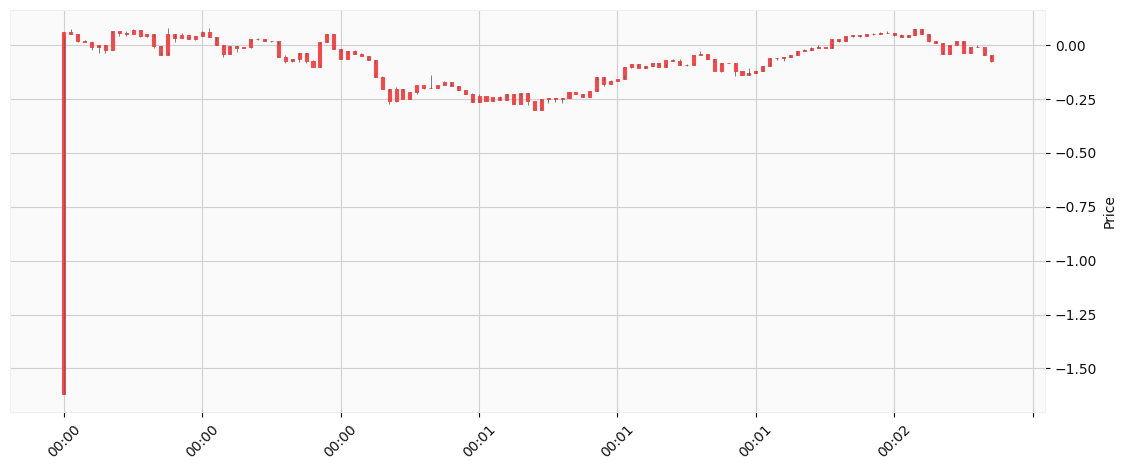

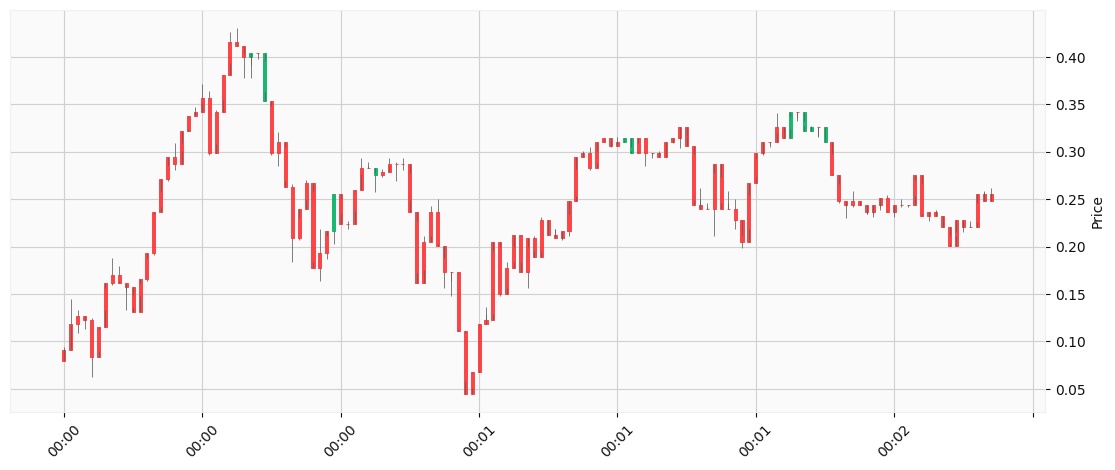

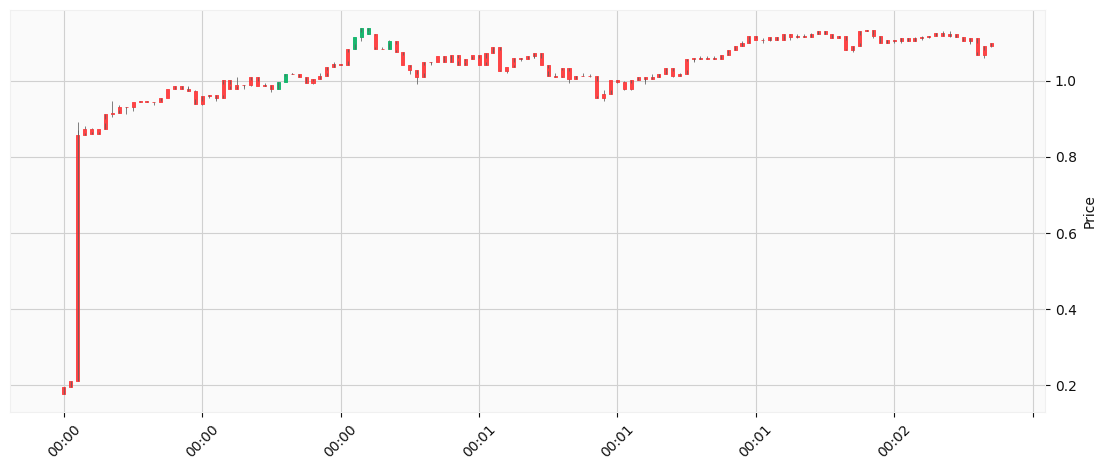

In [8]:
import mplfinance as mpf
import pandas as pd
import numpy as np
import copy
#from _Utility import swap

y_true = y_svm
y_pred = m_pred
y_pred2= y_svmpred

X_raw  = X_testraw

print(int(len(X_raw[:,0])/155))

num_candles = 155

iter = 0

for section in range(int(len(X_raw[:,0])/num_candles)):
	section*=num_candles
	section_end = section+num_candles
	X_thold = copy.deepcopy(X_testraw[section:section_end,:])

	h = X_thold[:,0]
	l = X_thold[:,1]
	c = X_thold[:,2]
	o = np.roll(c, shift=1)

	#small for loop to force direction of candle based on prediction of model
	for i in range(len(c)):
		#if predicts 1
		if(y_pred[section+i]==1):
			if(y_pred2[iter]==1):
				if(c[i]<o[i]):#force green
					c[i],o[i] = o[i],c[i]
			else:
				if(c[i]>o[i]):#force red
					c[i],o[i] = o[i],c[i]
			iter = iter + 1
		else:
			if(c[i]>o[i]):#force red
				c[i],o[i] = o[i],c[i]


	data = {
		'Date':range(0,len(X_thold[:])*1000000000,1000000000),
		'Open':o,
		'High':h,
		'Low':l,
		'Close':c
	}
	df = pd.DataFrame(data)
	#df['color'] = colors
	df['Date'] = pd.to_datetime(df['Date'])
	df.set_index('Date',inplace=True)

	mpf.plot(df[10:-10], type='candle',style='yahoo',figratio=(20,8))
	#mpf.plot(df, addplot=plot,style=custom_style,figratio=(20,8))

In [14]:
import _Master_Model
from importlib import reload
reload(_Master_Model)

loadsave = _Master_Model.Master(
	model_depth=3
)
loadsave.load_model('pred1_63p2_acc-645-800')
loadsave.level_2 = clf
loadsave.lvl2_findx = feats

loadsave.save_model()

Folder tree generated successfully.
PATH: tmp_model/level_0/model_0_0_0
keras saving complete
PATH: tmp_model/level_0/model_0_1_0
keras saving complete
PATH: tmp_model/level_0/model_0_2_0
keras saving complete
PATH: tmp_model/level_0/model_0_3_0
keras saving complete
PATH: tmp_model/level_0/model_1_0_0
keras saving complete
PATH: tmp_model/level_0/model_1_1_0
keras saving complete
PATH: tmp_model/level_0/model_1_2_0
keras saving complete
PATH: tmp_model/level_0/model_1_3_0
keras saving complete


In [18]:
import _Master_Model
from importlib import reload
reload(_Master_Model)

loadfinal = _Master_Model.Master(
	model_depth=3
)
loadfinal.load_model('tmp_model')

y_pred = loadfinal.master_predict(X_testraw, threshold=0.5)
print(precision_score(y_test, y_pred))

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(3093, 8)
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0.6663066954643628


Chronos: Predicting on Model #1 (tmp_model)
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
(25350, 8)
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Chronos Precision: 0.5967002749770852


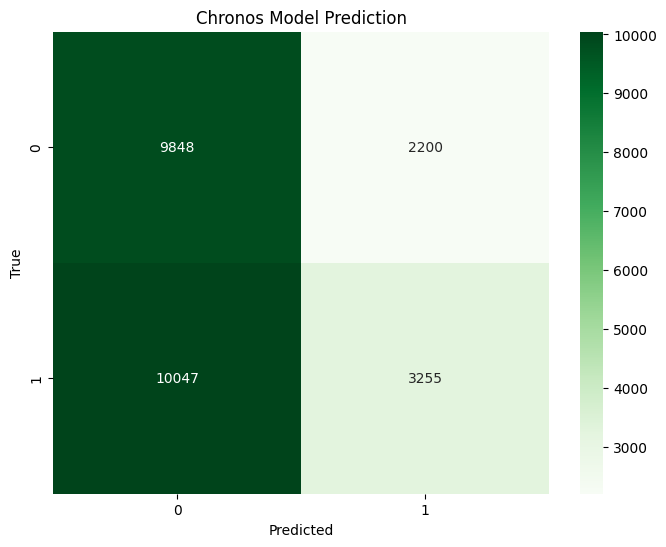

In [20]:
import _Time_Ensemble
from importlib import reload
reload(_Time_Ensemble)
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

chronos_pred = _Time_Ensemble.chronos_predict(X=X_loadraw, master_names=['tmp_model'])

print(f'Chronos Precision: {precision_score(y_loadraw, chronos_pred)}')
#Create the confusion matrix
cm = confusion_matrix(y_loadraw, chronos_pred)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', \
			xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Chronos Model Prediction')
plt.show()